# Working Notebook

In [1]:
import torch
from time_deconv.time_deconv_simulator import *
from time_deconv.time_deconv import *
from time_deconv.hypercluster import *

# Configure

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

n_iters = 5000

# Load data

In [3]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)

In [5]:
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [6]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [7]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc',
    hypercluster = True,
)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Reclustering B...
	9 subclusters identified
Reclustering Th...
	50 subclusters identified
Reclustering Mono...
	16 subclusters identified
Reclustering Tc...
	81 subclusters identified
Reclustering NK...
	94 subclusters identified
Reclustering Neut...
	16 subclusters identified
Keeping pDC...
Keeping Plasmablast...
Keeping cDC...
Keeping 55/266 clusters


# Run Deconvolution

In [8]:
#ebov_dataset.sc_anndata.obs['hypercluster']

In [9]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 5,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype
)

In [10]:
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000)

[step: 0, time: 1 s ] loss: 28746352.41
[step: 1000, time: 14 s ] loss: 8085888.51
[step: 2000, time: 28 s ] loss: 3273356.16
[step: 3000, time: 41 s ] loss: 1911126.25
[step: 4000, time: 54 s ] loss: 1399974.49


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

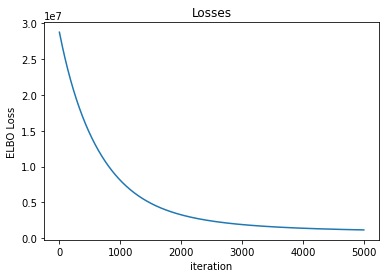

In [11]:
# plot the losses
pseudo_time_reg_deconv.plot_loss()

In [12]:
r = pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000, return_vals=True)

In [13]:
pseudo_time_reg_deconv.dataset.hypercluster_results.keys()

dict_keys(['cluster_map', 'new_clusters'])

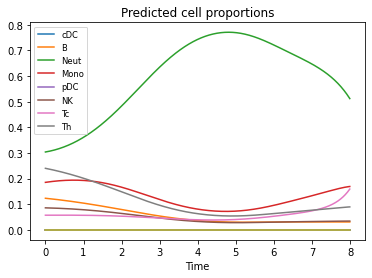

In [14]:
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

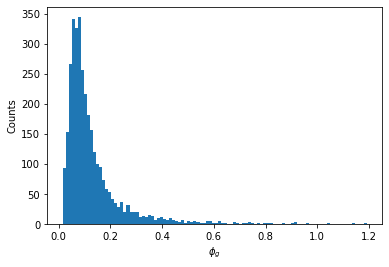

In [18]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

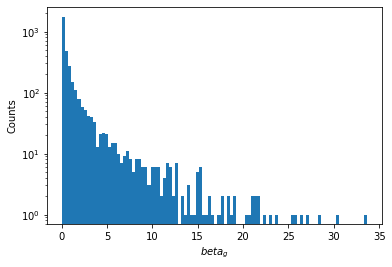

In [19]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

# Plot per sample deconvolution

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [21]:
math.ceil(3.)

3

IndexError: index 6 is out of bounds for axis 1 with size 6

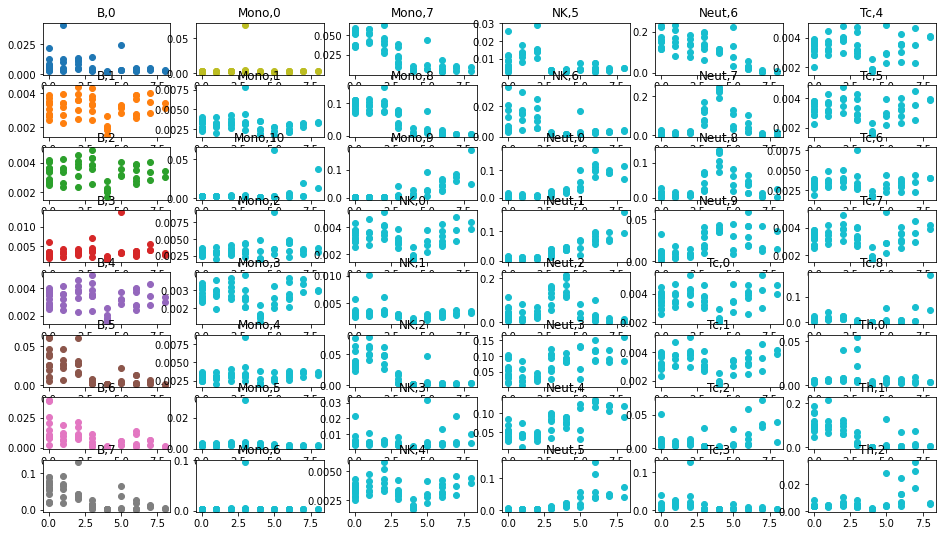

In [22]:
pseudo_time_reg_deconv.plot_sample_compositions_scatter()
matplotlib.pyplot.show()

In [ ]:
pseudo_time_reg_deconv.plot_sample_compositions_boxplot()
matplotlib.pyplot.show()

# Simulate and Evaluate

In [ ]:
# Simulate and plot 100 samples from a random trajectory 
# based on linear functions through a softmax

sim_res = simulate_data(
    num_samples=100, 
    reference_deconvolution=pseudo_time_reg_deconv, 
    trajectory_type='linear',
    seed = 100)

plot_simulated_proportions(sim_res)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
# Generate input AnnData object from the above simulation
simulated_bulk = generate_anndata_from_sim(
    sim_res, 
    reference_deconvolution = pseudo_time_reg_deconv)

# Generate a deconvolution dataset
ebov_simulated_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = simulated_bulk,
    bulk_time_col = "time",
    dtype_np = dtype_np,
    dtype = dtype,
    device = device,
    feature_selection_method = 'common' 
)

In [ ]:
# Set-up and run the deconvolution
pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
    dataset=ebov_simulated_dataset,
    polynomial_degree = 20,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

pseudo_time_reg_deconv_sim.fit_model(
    n_iters=5_001, 
    verbose=True, 
    log_frequency=1000
)

# Examine Outputs

In [ ]:
pseudo_time_reg_deconv_sim.plot_loss()

In [ ]:
pseudo_time_reg_deconv_sim.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv_sim.plot_composition_trajectories()

In [ ]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

In [ ]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

In [ ]:
# examine the alphas

alphas = list(pseudo_time_reg_deconv.param_store_hist[i]['dirichlet_alpha'] for i in range(len(pseudo_time_reg_deconv.param_store_hist)))

fig, ax = matplotlib.pyplot.subplots(1,2)

ax[0].plot(alphas)
ax[0].set_title(r'Dirichlet $ \alpha $ Values')

ax[1].plot(alphas[-500:])
ax[1].set_title(r'Last few Dirichlet $ \alpha $ Values')

In [ ]:
calculate_trajectory_prediction_error(sim_res, pseudo_time_reg_deconv_sim)

In [ ]:
sim_res['trajectory_params']['trajectories_cm'].shape

In [ ]:
sim_res['cell_pop_cm'].shape

In [ ]:
def calculate_sample_prediction_error(sim_res, pseudo_time_reg_deconv_sim):
    # Ground Truth
    ground_truth_cell_pop_cm = sim_res['cell_pop_cm']
    estimated_cell_pop_cm = pyro.param("cell_pop_posterior_loc_mc").clone().detach().cpu().T
    
    l1_error = (ground_truth_cell_pop_cm - estimated_cell_pop_cm).abs().sum([0,1])
    l1_error_norm = l1_error / estimated_cell_pop_cm.shape[-1]
    
    return {
        'l1_error': l1_error,
        'l1_error_norm': l1_error_norm
    }

In [ ]:
calculate_sample_prediction_error(sim_res, pseudo_time_reg_deconv_sim)